In [1]:
import numpy as np
import pandas as pd
from eofs.standard import Eof
import matplotlib.pyplot as plt

In [23]:
def trans_linear_to_2D(data, side_length = 9):
    """Transforms an array of the shape (timesteps, number_grid_p) into (timesteps, sqrt(number_grid_p),sqrt(number_grid_p))"""
    t_length, linear_length = data.shape
    assert linear_length == side_length**2
    
    reshaped_data = np.reshape(data,(t_length,side_length,side_length), order = 'F')
    return reshaped_data

def trans_2D_into_linear(data):
    """Transforms an array of the shape (timesteps, sqrt(number_grid_p),sqrt(number_grid_p)) into (timesteps, number_grid_p)"""
    t_length, side_length, side_length_y= data.shape
    assert side_length == side_length_y
    reshaped_data = np.reshape(data,(t_length,side_length**2),order = 'F')
    
    return reshaped_data
    

In [214]:
def reconstruct(eofs, pcs):
    """Function that reconstructs Fields from EOF and PC"""
    time_length, spatial_length = pcs.shape
    reconstructed_field = np.zeros(pcs.shape)
    
    for i in range(time_length):
        reconstructed_field[i,:] = np.sum(eofs*pcs[i,:,None], axis =0)
    return reconstructed_field

In [212]:
def get_eofs(eof_rawdata):
    """Do EOF analysis and give out Eof, PC and corresponding variance"""
    solver = Eof(eof_rawdata,weights=None)
    eofs = solver.eofs()
    variance_fraction = solver.varianceFraction()
    pcs = solver.pcs()
    pseudo_pcs = solver.projectField(eof_rawdata)
    return eofs, pseudo_pcs, variance_fraction


In [3]:
v_x_pandas=pd.read_csv('velocity_x.csv')
v_y_pandas=pd.read_csv('velocity_y.csv')

In [4]:
v_x=v_x_pandas.values[:,1:]
v_y=v_y_pandas.values[:,1:]

**U and V Seperated analysed in 1D**

In [213]:
eofs_x, pcs_x, variance_x = get_eofs(v_x)
eofs_y, pcs_y, variance_y = get_eofs(v_y)

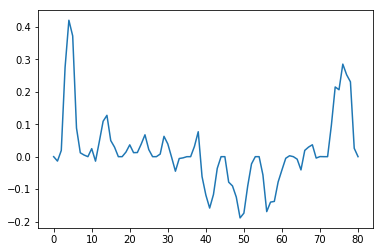

In [7]:
plt.plot(eofs_x[0])

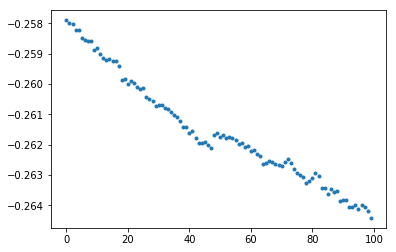

In [8]:
plt.plot(pcs_x[-100:,0],'.')

**2D Analysis**, is not necessary, we demonstrate, that it does not matter if we do it in 2D or 1D

In [91]:
v_x_2D = trans_linear_to_2D(v_x)
v_y_2D = trans_linear_to_2D(v_y)

In [92]:
eofs_x_2D, pcs_x_2D, variance_x_2D = get_eofs(v_x_2D)

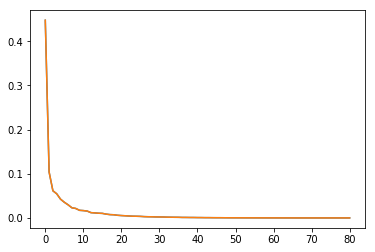

In [93]:
plt.plot(variance_x_2D)
plt.plot(variance_x)

In [94]:
trans_eofs_x_2D = trans_2D_into_linear(eofs_x_2D)

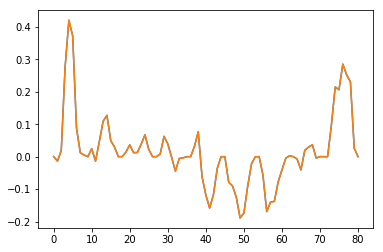

In [95]:
plt.plot(eofs_x[0,:])
plt.plot(trans_eofs_x_2D[0,:])

**Test**, Can perfectly reconstruct field, and EoFs are orthogonal

In [215]:
reconstructed_field_fun = reconstruct(eofs_x, pcs_x)

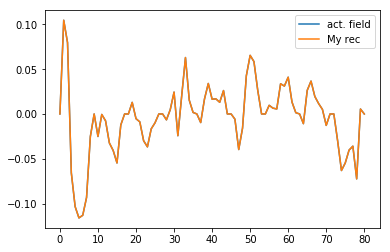

In [223]:
plt.plot(v_x[t_step,:],label = "act. field")
plt.plot(reconstructed_field_fun[t_step,:], label = "My rec")
plt.legend()

In [221]:
#Test of Orthogonality
for j in range(81):
    for i in range(81):
        diag_sum = np.sum(eofs_x[j,:]*eofs_x[i,:])
        if diag_sum>1e-14:
            print(diag_sum, i, j)

1.0000000000000002 0 0
1.0000000000000016 1 1
1.0 2 2
1.0 3 3
0.9999999999999989 4 4
1.0 5 5
1.0000000000000004 6 6
0.9999999999999993 7 7
1.0 8 8
0.9999999999999987 9 9
1.0000000000000004 10 10
1.0 11 11
0.9999999999999982 12 12
1.0000000000000004 13 13
1.0000000000000004 14 14
1.0 15 15
1.0 16 16
1.0000000000000004 17 17
1.0000000000000002 18 18
0.9999999999999996 19 19
1.0000000000000007 20 20
0.9999999999999998 21 21
1.0000000000000004 22 22
0.9999999999999989 23 23
0.9999999999999991 24 24
1.0 25 25
0.999999999999999 26 26
0.9999999999999991 27 27
1.0 28 28
0.9999999999999998 29 29
1.0000000000000004 30 30
0.9999999999999997 31 31
1.0 32 32
0.9999999999999987 33 33
0.9999999999999984 34 34
0.9999999999999989 35 35
0.9999999999999987 36 36
0.9999999999999996 37 37
0.9999999999999998 38 38
0.9999999999999993 39 39
1.0000000000000002 40 40
0.9999999999999998 41 41
0.9999999999999999 42 42
1.0000000000000004 43 43
0.9999999999999999 44 44
1.0000000000000004 45 45
1.0000000000000007 46